### Description of fer2013 dataset from Kaggle

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [1]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
from sklearn.metrics import classification_report

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [5]:
import scikitplot
import seaborn as sns
from matplotlib import pyplot

In [6]:
from sklearn.metrics import classification_report

Data preprocessing

In [7]:
#reading the data from csv file from kaggle
data = pd.read_csv('./fer2013.csv')

width, height = 48, 48
datapoints = data['pixels'].tolist()

#getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

#getting labels for training
y = pd.get_dummies(data['emotion']).to_numpy()

#storing them using numpy
np.save('fdataX', X)
np.save('flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+ str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")

Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


In [44]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

In [9]:
x = np.load('./fdataX.npy')
y = np.load('./flabels.npy')

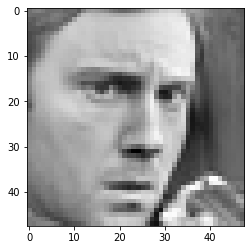

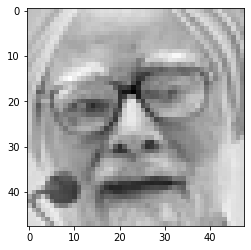

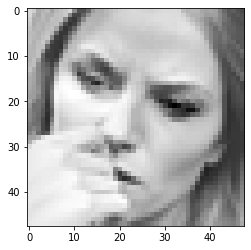

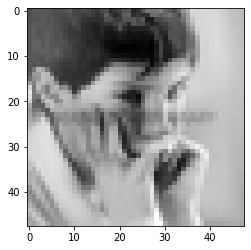

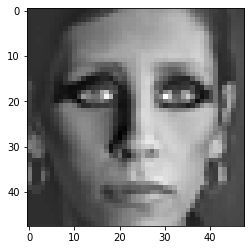

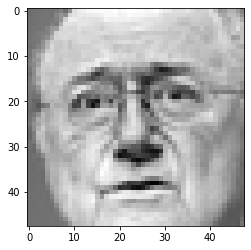

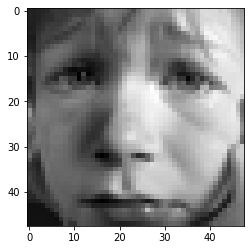

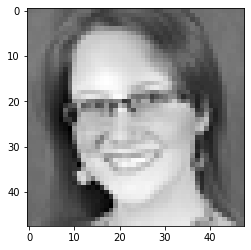

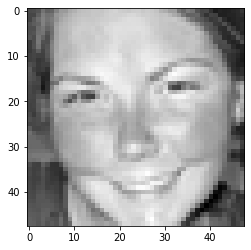

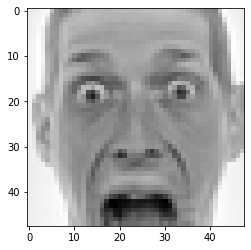

In [10]:
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

for xx in range(10):
    pyplot.figure(xx)
    pyplot.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
    pyplot.show()

#splitting into test and train sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
#splitting train to train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the samples to be used later
np.save('modXtest', X_test)
np.save('modytest', y_test)

np.save('modXtrain', X_train)
np.save('modytrain', y_train)

np.save('modXvalid', X_valid)
np.save('modyvalid', y_valid)

Create data generator

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

Create callbacks for early stopping of training process and reducing learing rate when training is not satisfactory

In [12]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

Image dimensions

In [13]:
img_width = 48
img_height = 48
img_depth =1

### Small model

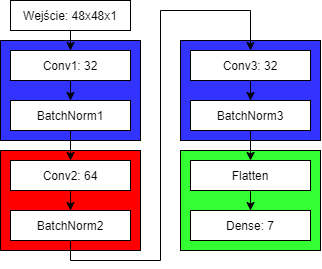

In [14]:
#create model
model = Sequential()

#add model layers
model.add(Conv2D(        
    filters=32,
    input_shape=(img_width, img_height, img_depth),
    kernel_size=(3,3),
    activation='relu',
    padding='same',
    kernel_initializer='he_normal'
))
model.add(BatchNormalization())
model.add(Conv2D(        
    filters=64,
    kernel_size=(3,3),
    activation='relu',
    padding='same',
    kernel_initializer='he_normal'
))
model.add(BatchNormalization())
model.add(Conv2D(        
    filters=32,
    kernel_size=(3,3),
    activation='relu',
    padding='same',
    kernel_initializer='he_normal'
))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(7, activation='softmax'))

In [15]:
#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [16]:
#training the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
454/454 [==============================] - 146s 321ms/step - loss: 6.2259 - accuracy: 0.2269 - val_loss: 4.3000 - val_accuracy: 0.2960
Epoch 2/20
454/454 [==============================] - 145s 319ms/step - loss: 2.9393 - accuracy: 0.2772 - val_loss: 1.7822 - val_accuracy: 0.3387
Epoch 3/20
454/454 [==============================] - 145s 320ms/step - loss: 1.6914 - accuracy: 0.3366 - val_loss: 1.5495 - val_accuracy: 0.3975
Epoch 4/20
454/454 [==============================] - 145s 319ms/step - loss: 1.6004 - accuracy: 0.3736 - val_loss: 1.5246 - val_accuracy: 0.4136
Epoch 5/20
454/454 [==============================] - 145s 319ms/step - loss: 1.5614 - accuracy: 0.3937 - val_loss: 1.4327 - val_accuracy: 0.4455
Epoch 6/20
454/454 [==============================] - 144s 317ms/step - loss: 1.5394 - accuracy: 0.4029 - val_loss: 1.4303 - val_accuracy: 0.4480
Epoch 7/20
454/454 [==============================] - 145s 319ms/step - loss: 1.5176 - accuracy: 0.4112 - val_loss: 1.4229 -

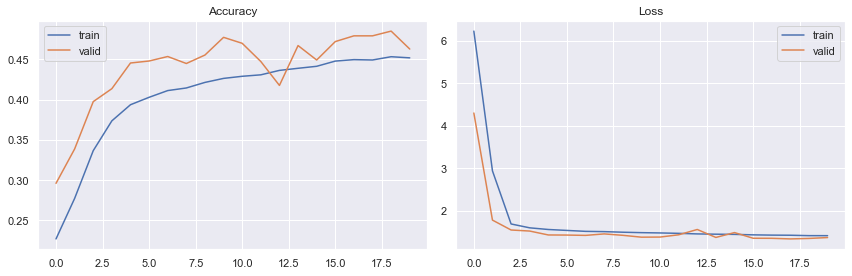

In [19]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_small_model.png')
pyplot.show()

total wrong validation predictions: 1929


              precision    recall  f1-score   support

           0       0.26      0.56      0.36       498
           1       0.00      0.00      0.00        52
           2       0.36      0.16      0.22       545
           3       0.66      0.80      0.73       881
           4       0.37      0.15      0.22       588
           5       0.55      0.68      0.61       414
           6       0.46      0.35      0.40       611

    accuracy                           0.46      3589
   macro avg       0.38      0.39      0.36      3589
weighted avg       0.46      0.46      0.43      3589



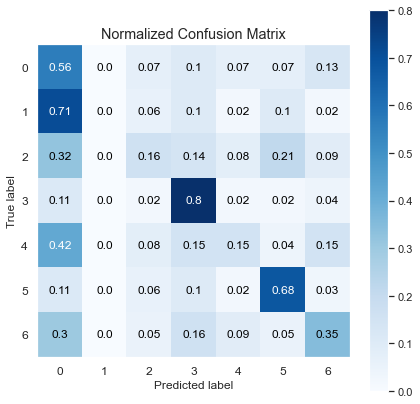

In [20]:
yhat_valid = model.predict_classes(X_test)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_valid, figsize=(7,7), normalize=True)

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_valid))

In [21]:
model.save('small_model.h5')

### Big model
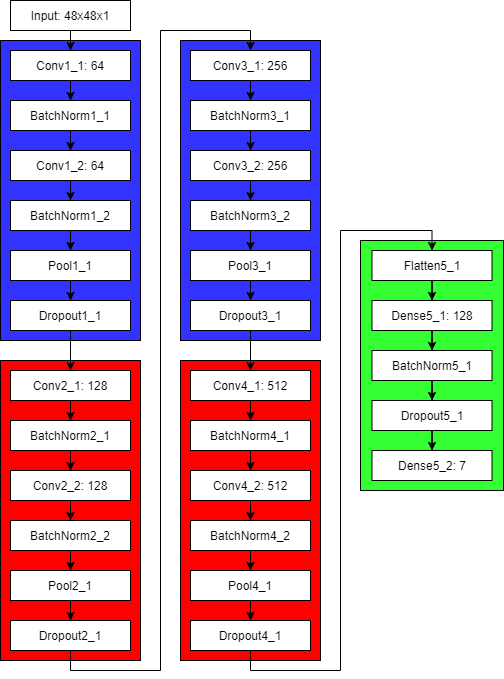

In [22]:
#create model
model2 = Sequential()


model2.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=(img_width, img_height, img_depth),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )
)
model2.add(BatchNormalization(name='batchnorm_1'))
model2.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )
)
model2.add(BatchNormalization(name='batchnorm_2'))

model2.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model2.add(Dropout(0.4, name='dropout_1'))

model2.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )
)
model2.add(BatchNormalization(name='batchnorm_3'))
model2.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )
)
model2.add(BatchNormalization(name='batchnorm_4'))

model2.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model2.add(Dropout(0.4, name='dropout_2'))

model2.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )
)
model2.add(BatchNormalization(name='batchnorm_5'))

model2.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )
)
model2.add(BatchNormalization(name='batchnorm_6'))

model2.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model2.add(Dropout(0.5, name='dropout_3'))

model2.add(
    Conv2D(
        filters=512,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_7'
    )
)
model2.add(BatchNormalization(name='batchnorm_7'))

model2.add(
    Conv2D(
        filters=512,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_8'
    )
)
model2.add(BatchNormalization(name='batchnorm_8'))

model2.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_4'))
model2.add(Dropout(0.5, name='dropout_4'))




model2.add(Flatten(name='flatten'))

model2.add(
    Dense(
        128,
        activation='relu',
        kernel_initializer='he_normal',
        name='dense_1'
    )
)
model2.add(BatchNormalization(name='batchnorm_9'))

model2.add(Dropout(0.6, name='dropout_5'))

model2.add(
    Dense(
        7,
        activation='softmax',
        name='out_layer'
    )
)

In [23]:
#Compliling the model with adam optimixer and categorical crossentropy loss
model2.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [24]:
batch_size = 32
epochs = 100
optims = [
  optimizers.Nadam(
      learning_rate=0.001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      name='Nadam'),
    
  optimizers.Adam(0.001),
]

In [25]:
#training the model
history2 = model2.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
908/908 [==============================] - 562s 617ms/step - loss: 2.1474 - accuracy: 0.2149 - val_loss: 1.7372 - val_accuracy: 0.2848
Epoch 2/100
908/908 [==============================] - 557s 613ms/step - loss: 1.7528 - accuracy: 0.2981 - val_loss: 1.5955 - val_accuracy: 0.3635
Epoch 3/100
908/908 [==============================] - 558s 614ms/step - loss: 1.6025 - accuracy: 0.3678 - val_loss: 1.3943 - val_accuracy: 0.4533
Epoch 4/100
908/908 [==============================] - 557s 613ms/step - loss: 1.4633 - accuracy: 0.4340 - val_loss: 1.3565 - val_accuracy: 0.4765
Epoch 5/100
908/908 [==============================] - 558s 614ms/step - loss: 1.3816 - accuracy: 0.4712 - val_loss: 1.2219 - val_accuracy: 0.5387
Epoch 6/100
908/908 [==============================] - 558s 615ms/step - loss: 1.3160 - accuracy: 0.5021 - val_loss: 1.1708 - val_accuracy: 0.5582
Epoch 7/100
908/908 [==============================] - 558s 614ms/step - loss: 1.2760 - accuracy: 0.5194 - val_loss: 1


Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 56/100
908/908 [==============================] - 559s 615ms/step - loss: 0.7961 - accuracy: 0.7070 - val_loss: 0.8760 - val_accuracy: 0.6907
Epoch 57/100
908/908 [==============================] - 557s 614ms/step - loss: 0.7986 - accuracy: 0.7073 - val_loss: 0.8803 - val_accuracy: 0.6876
Epoch 58/100
908/908 [==============================] - 558s 614ms/step - loss: 0.7937 - accuracy: 0.7117 - val_loss: 0.8766 - val_accuracy: 0.6870
Epoch 59/100
908/908 [==============================] - 557s 613ms/step - loss: 0.7896 - accuracy: 0.7098 - val_loss: 0.8744 - val_accuracy: 0.6907
Epoch 60/100
908/908 [==============================] - 557s 613ms/step - loss: 0.7790 - accuracy: 0.7153 - val_loss: 0.8809 - val_accuracy: 0.6944
Epoch 61/100
908/908 [==============================] - 557s 613ms/step - loss: 0.7824 - accuracy: 0.7150 - val_loss: 0.8839 - val_accuracy: 0.6950
Epoch 62/100
908/908 [=========

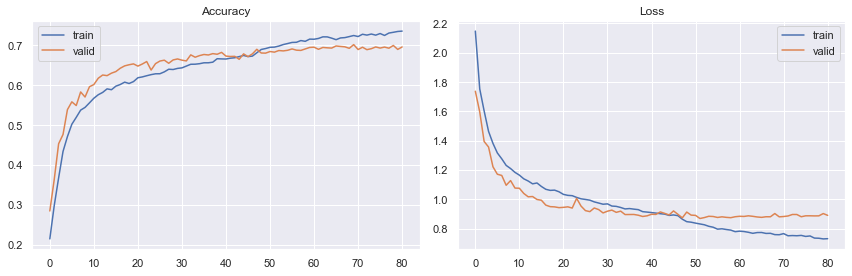

In [26]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history2.epoch, history2.history['accuracy'], label='train')
sns.lineplot(history2.epoch, history2.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history2.epoch, history2.history['loss'], label='train')
sns.lineplot(history2.epoch, history2.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_big_model.png')
pyplot.show()

total wrong validation predictions: 1133


              precision    recall  f1-score   support

           0       0.62      0.62      0.62       498
           1       0.72      0.63      0.67        52
           2       0.62      0.48      0.54       545
           3       0.87      0.87      0.87       881
           4       0.58      0.53      0.55       588
           5       0.75      0.75      0.75       414
           6       0.59      0.76      0.66       611

    accuracy                           0.68      3589
   macro avg       0.68      0.66      0.67      3589
weighted avg       0.69      0.68      0.68      3589



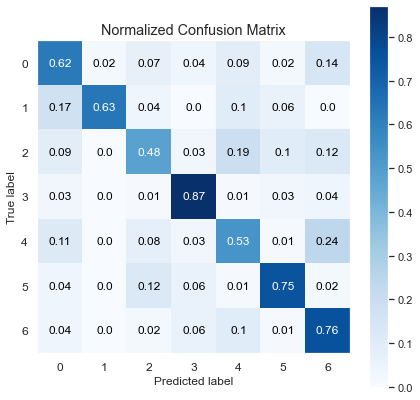

In [27]:
yhat_valid = model2.predict_classes(X_test)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_valid, figsize=(7,7), normalize=True)

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_valid))

In [28]:
model2.save('big_model.h5')

# ANOTHER IDEA: use pretrained VGG16 and see how it performs


In [29]:
from tensorflow.keras.applications import VGG16

issue with using pretrained VGG model is need to use all 3 channels due to its training on colored images so to achive that in this case I will duplicate grayscale object 3 times.

In [30]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

In [31]:
X_train_duppedx3 = np.concatenate((X_train,)*3, axis=-1) 
y_train_duppedx3 = np.concatenate((y_train,)*3, axis=-1) 
X_valid_duppedx3 = np.concatenate((X_valid,)*3, axis=-1) 
y_valid_duppedx3 = np.concatenate((y_valid,)*3, axis=-1) 

In [32]:
print(X_train_duppedx3.shape)
print(y_train_duppedx3.shape)
print(X_valid_duppedx3.shape)
print(y_valid_duppedx3.shape)

(29068, 48, 48, 3)
(29068, 21)
(3230, 48, 48, 3)
(3230, 21)


We had problems with fitting the model because i dupped not only the data but also the labels and was trying to use "y_train_duppedx3" with 21 outputs insted of 7

In [33]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [34]:
early_stopping = EarlyStopping(
    monitor='val_acc',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [35]:
X_test_duppedx3 = np.concatenate((X_test,)*3, axis=-1) 
y_test_duppedx3 = np.concatenate((y_test,)*3, axis=-1) 

In [36]:
model3 = Sequential()
model3.add(conv_base)
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(7, activation='sigmoid'))

In [37]:
model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [38]:
history3 = model3.fit(
    train_datagen.flow(X_train_duppedx3, y_train, batch_size=batch_size),
    validation_data=(X_valid_duppedx3, y_valid),
    steps_per_epoch=len(X_train_duppedx3) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
908/908 [==============================] - 247s 271ms/step - loss: 0.3764 - acc: 0.3304 - val_loss: 0.3265 - val_acc: 0.4390
Epoch 2/100
908/908 [==============================] - 244s 269ms/step - loss: 0.3426 - acc: 0.4068 - val_loss: 0.3147 - val_acc: 0.4582
Epoch 3/100
908/908 [==============================] - 243s 267ms/step - loss: 0.3301 - acc: 0.4336 - val_loss: 0.3008 - val_acc: 0.4833
Epoch 4/100
908/908 [==============================] - 244s 268ms/step - loss: 0.3209 - acc: 0.4541 - val_loss: 0.2953 - val_acc: 0.4972
Epoch 5/100
908/908 [==============================] - 242s 266ms/step - loss: 0.3148 - acc: 0.4634 - val_loss: 0.2893 - val_acc: 0.5087
Epoch 6/100
908/908 [==============================] - 242s 266ms/step - loss: 0.3097 - acc: 0.4750 - val_loss: 0.2881 - val_acc: 0.5130
Epoch 7/100
908/908 [==============================] - 242s 266ms/step - loss: 0.3044 - acc: 0.4862 - val_loss: 0.2832 - val_acc: 0.5207
Epoch 8/100
908/908 [====================

908/908 [==============================] - 243s 267ms/step - loss: 0.2146 - acc: 0.6691 - val_loss: 0.2590 - val_acc: 0.6071
Epoch 60/100
908/908 [==============================] - 242s 267ms/step - loss: 0.2149 - acc: 0.6696 - val_loss: 0.2582 - val_acc: 0.6087
Epoch 61/100
908/908 [==============================] - 242s 267ms/step - loss: 0.2141 - acc: 0.6678 - val_loss: 0.2592 - val_acc: 0.6084
Epoch 62/100
908/908 [==============================] - 242s 267ms/step - loss: 0.2142 - acc: 0.6700 - val_loss: 0.2560 - val_acc: 0.6015
Epoch 63/100
908/908 [==============================] - 242s 267ms/step - loss: 0.2135 - acc: 0.6730 - val_loss: 0.2588 - val_acc: 0.6059
Epoch 64/100
908/908 [==============================] - 243s 267ms/step - loss: 0.2123 - acc: 0.6730 - val_loss: 0.2619 - val_acc: 0.6043
Epoch 65/100
908/908 [==============================] - 243s 267ms/step - loss: 0.2112 - acc: 0.6757 - val_loss: 0.2622 - val_acc: 0.6028
Epoch 66/100
908/908 [=========================

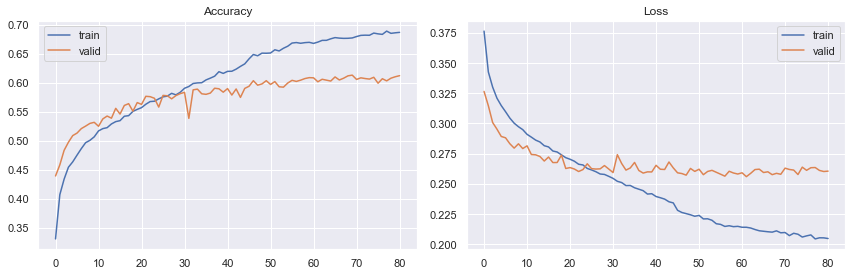

In [40]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history3.epoch, history3.history['acc'], label='train')
sns.lineplot(history3.epoch, history3.history['val_acc'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history3.epoch, history3.history['loss'], label='train')
sns.lineplot(history3.epoch, history3.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_transfer_learning.png')
pyplot.show()

total wrong validation predictions: 1512


              precision    recall  f1-score   support

           0       0.48      0.47      0.47       498
           1       0.47      0.31      0.37        52
           2       0.56      0.37      0.45       545
           3       0.74      0.78      0.76       881
           4       0.45      0.49      0.47       588
           5       0.69      0.72      0.70       414
           6       0.49      0.59      0.54       611

    accuracy                           0.58      3589
   macro avg       0.56      0.53      0.54      3589
weighted avg       0.58      0.58      0.57      3589



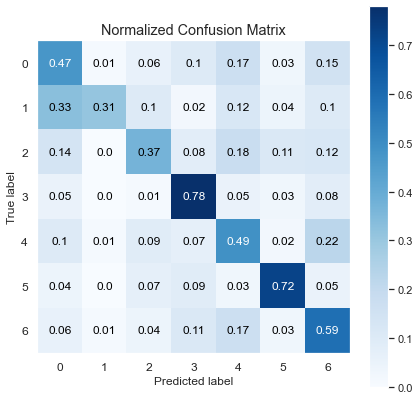

In [43]:
yhat_valid = model3.predict_classes(X_test_duppedx3)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test_duppedx3, axis=1), yhat_valid, figsize=(7,7), normalize=True)

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test_duppedx3, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test_duppedx3, axis=1), yhat_valid))

In [42]:
model3.save('transfer_learning_model.h5')

#### Usage of smaller Dropout is helpful but now we can see overfitting of the model

### Maybe this specific data is troublesome for cnns to work on.

That is also covered by the authors of the dataset. They state that even humans had trouble with categorising emotions on photos they provided. They say that we can achive accuracy around 65 +/- 5%. Having this in mind the models provided in this project all behave almost similart to what we could exspect from humans. Therefore We are satisfied with the results we obtained.